In [ ]:
# Figure 13-(abc) and 14 in sensitivity analysis
# plot the harvest amount for each scenario and calculate the total harvest
# Then plot all the harvest amounts in the same figure (Figure 14)

# 这个notebook包含了论文中，图13-(abc)和图14的绘制代码
# 代码其实基本都是重复的，区别仅在于参数不同。
# 由于赛中时间紧迫，因此直接复制粘贴修改参数，可读性较差，敬请谅解。
# 此notebook拖到最后可以看到我们绘制的条形图，用于展示收获量的敏感性分析


# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt

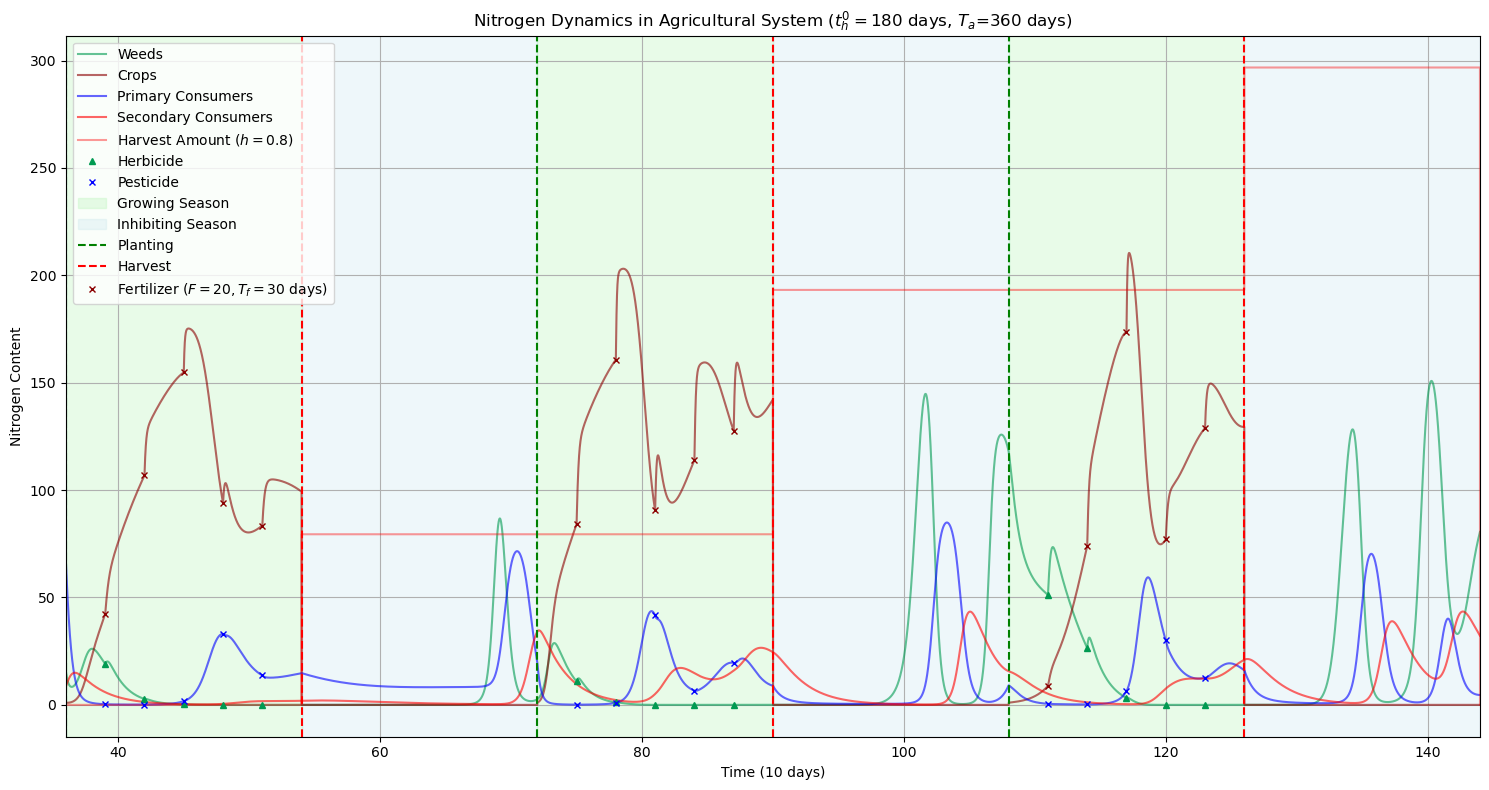

296.78831907010857


In [ ]:
# Figure 13-a Both insecticides and herbicides
# Competition coefficients
c_wc = 0.0005
c_cw = 0.0002

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 3             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])

d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 100
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
print(harvest[-2])

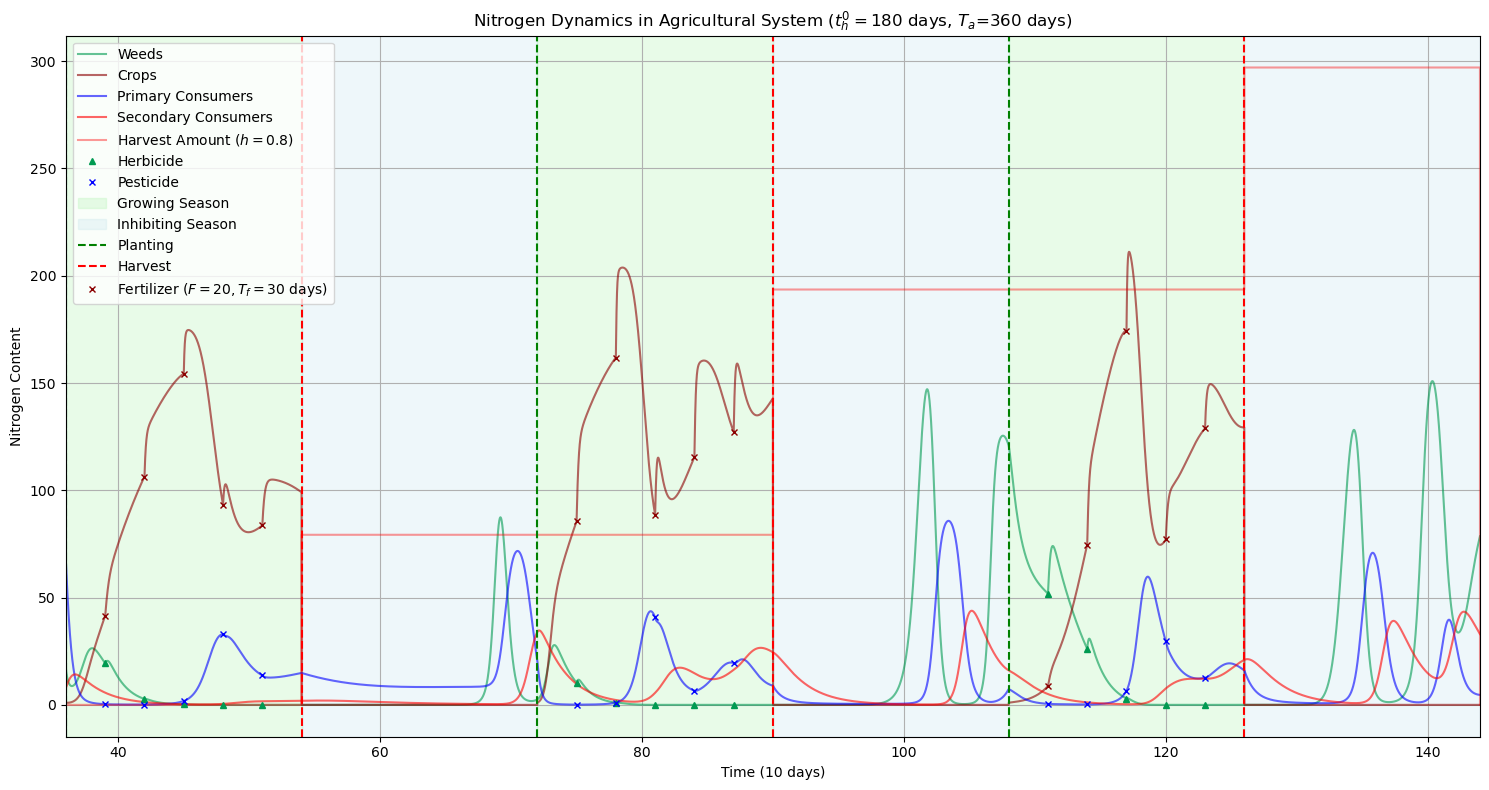

297.0648714534071


In [ ]:
# Figure 13-b Both insecticides and herbicides
# Competition coefficients
c_wc = 0.0003
c_cw = 0.0003

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 3             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])

d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 100
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
print(harvest[-2])

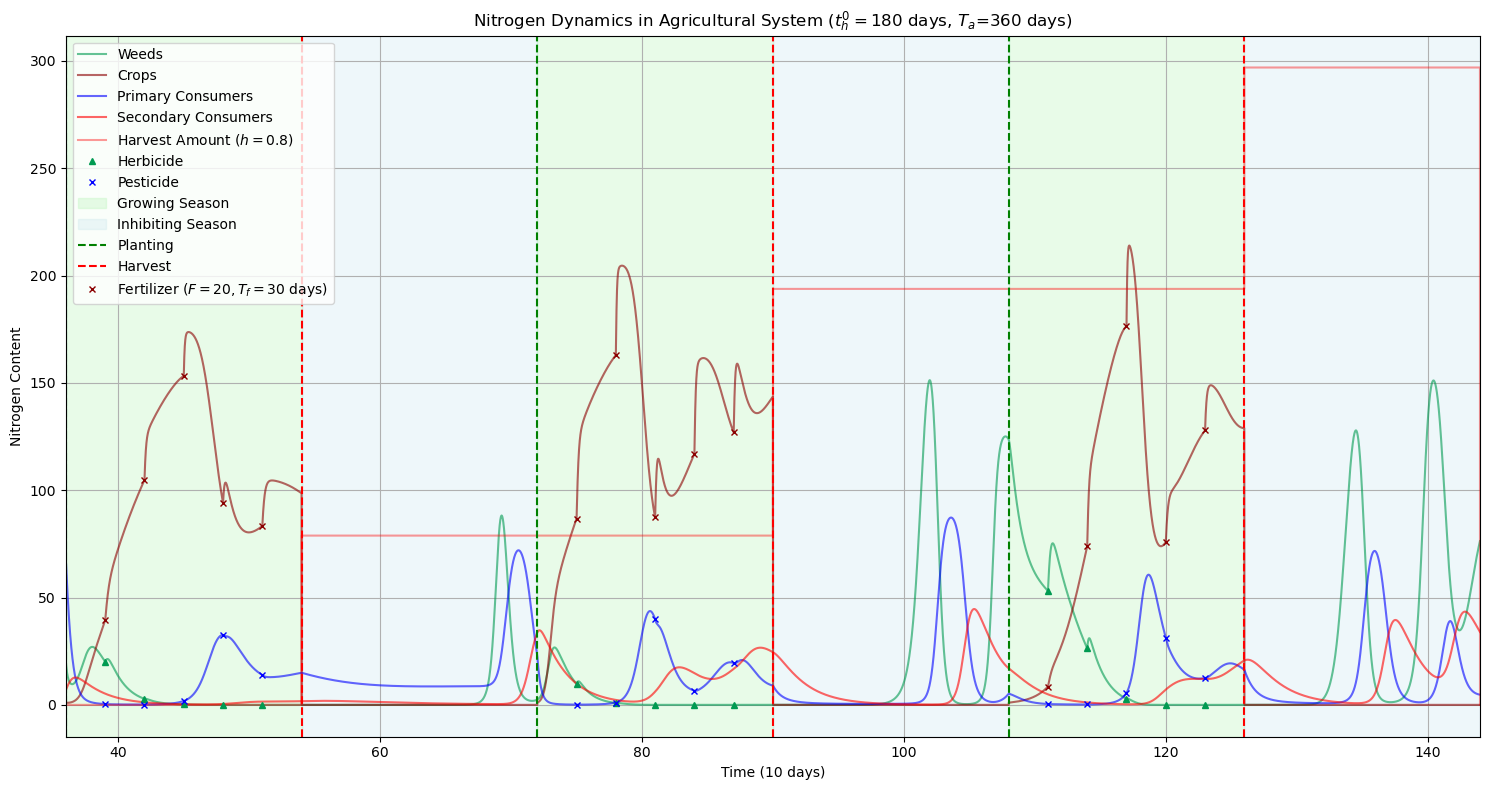

296.9122727378709


In [ ]:
# Figure 13-c Both insecticides and herbicides
# Competition coefficients
c_wc = 0.0002
c_cw = 0.0005

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 3             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])

d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 100
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()
print(harvest[-2])

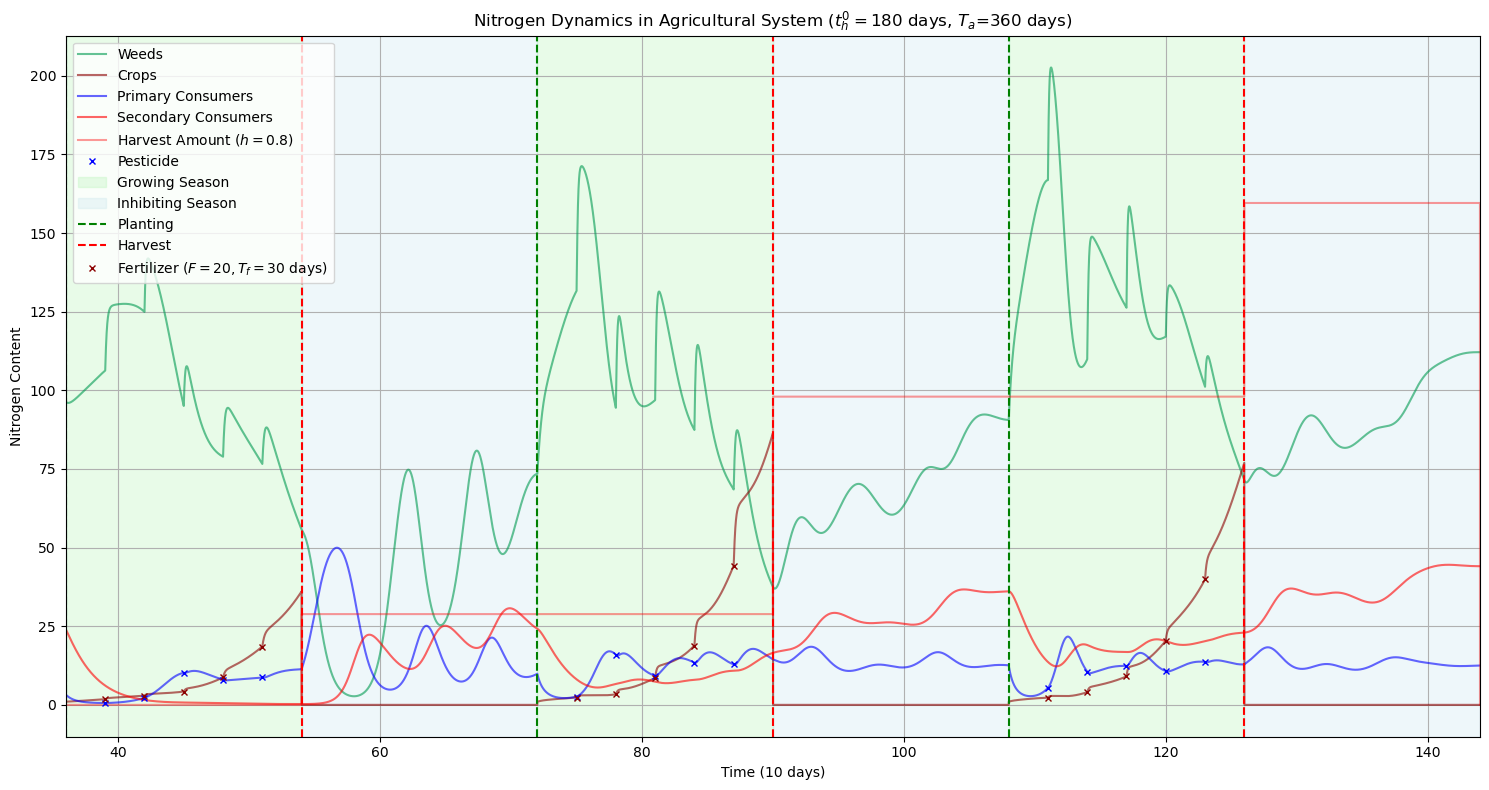

159.56769993215943


In [ ]:
# Only insecticides and no herbicide
# Competition coefficients
c_wc = 0.0005
c_cw = 0.0002

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

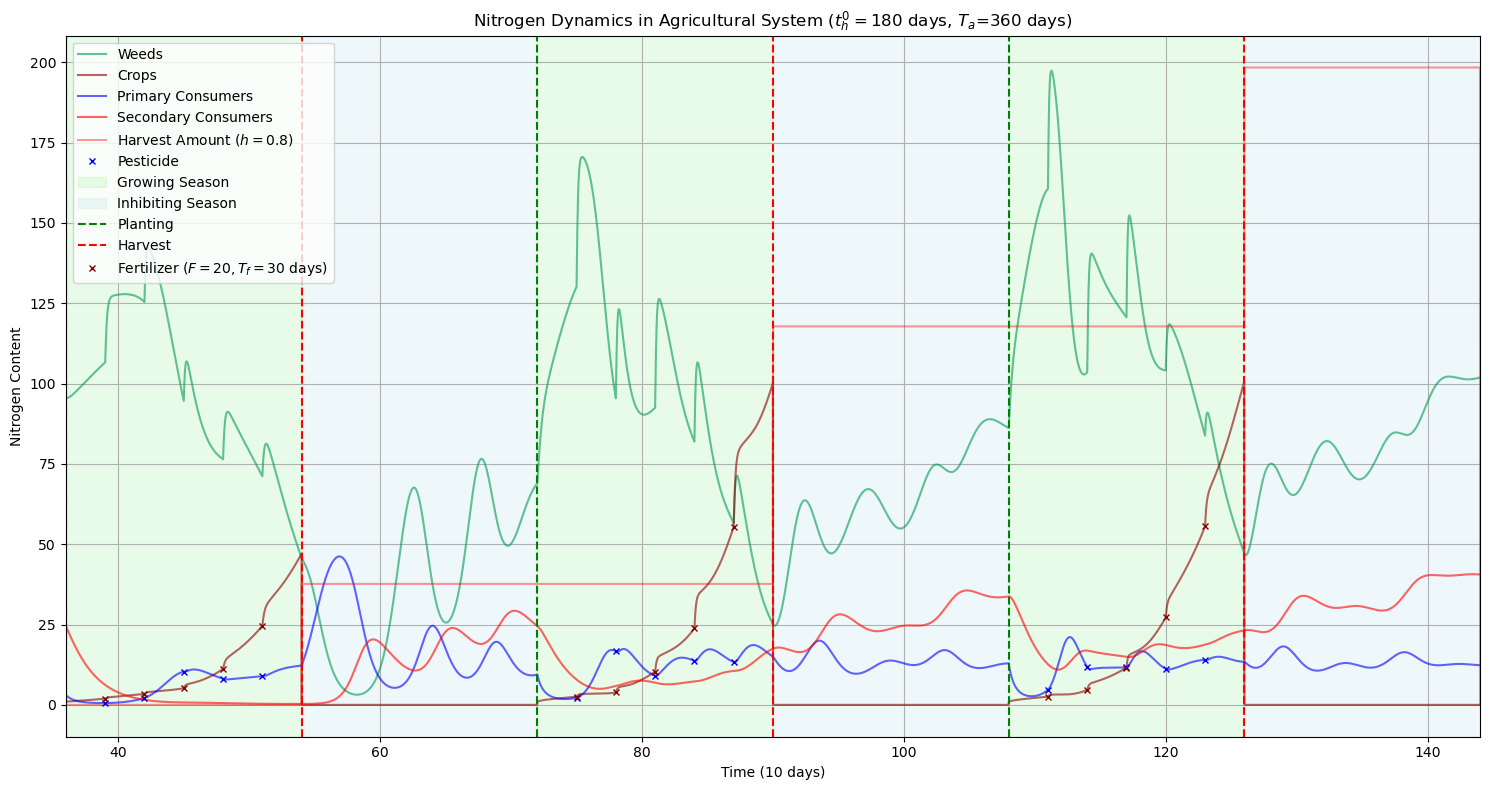

198.37053901804433


In [ ]:
# Only insecticides and no herbicide
# Competition coefficients
c_wc = 0.0003
c_cw = 0.0003

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

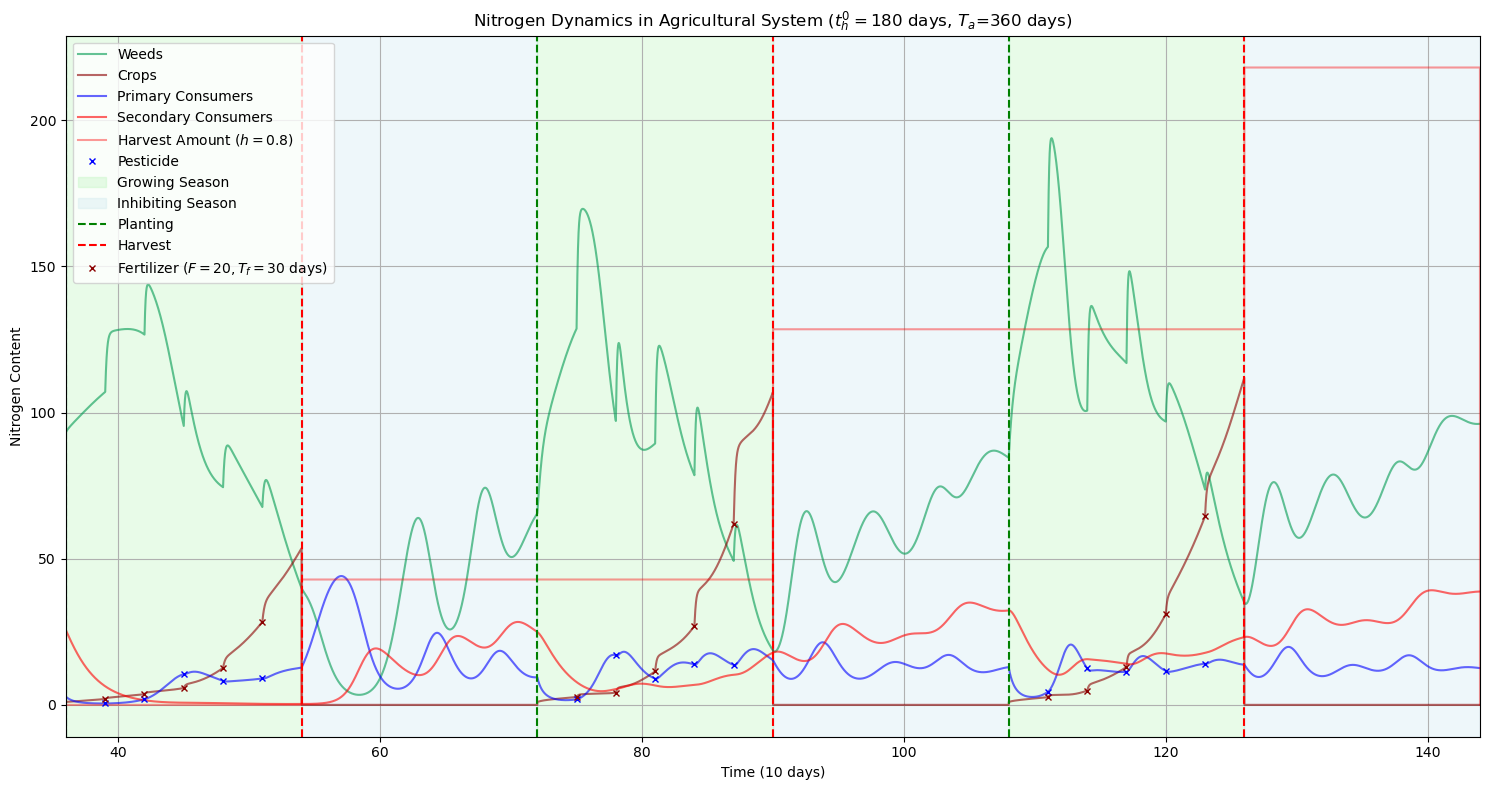

218.0844431534706


In [ ]:
# Only insecticides and no herbicide
# Competition coefficients
c_wc = 0.0002
c_cw = 0.0005

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

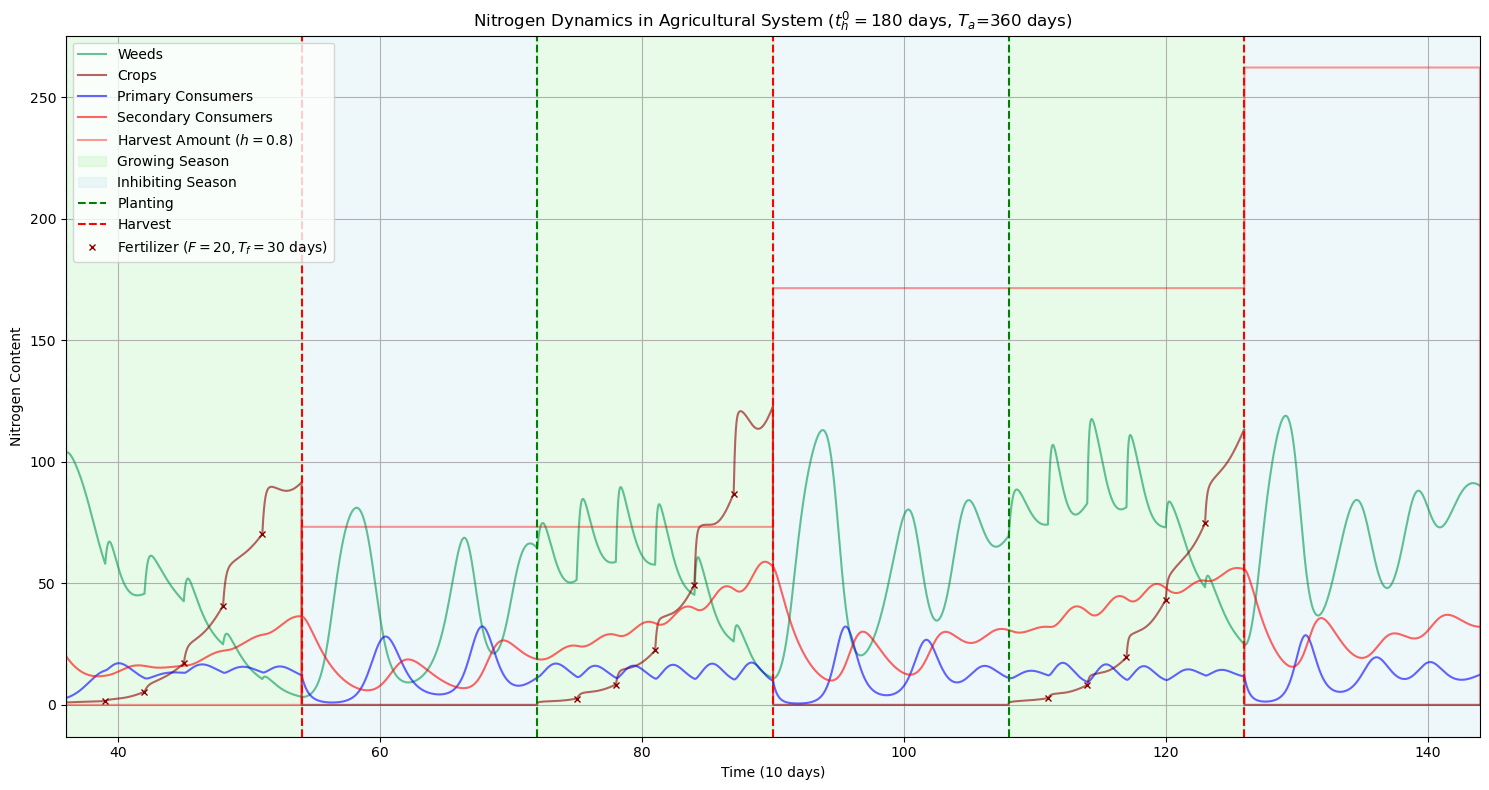

262.1529642856306


In [ ]:
# neither insecticides nor herbicide
# Competition coefficients
c_wc = 0.0005
c_cw = 0.0002

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 30000             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

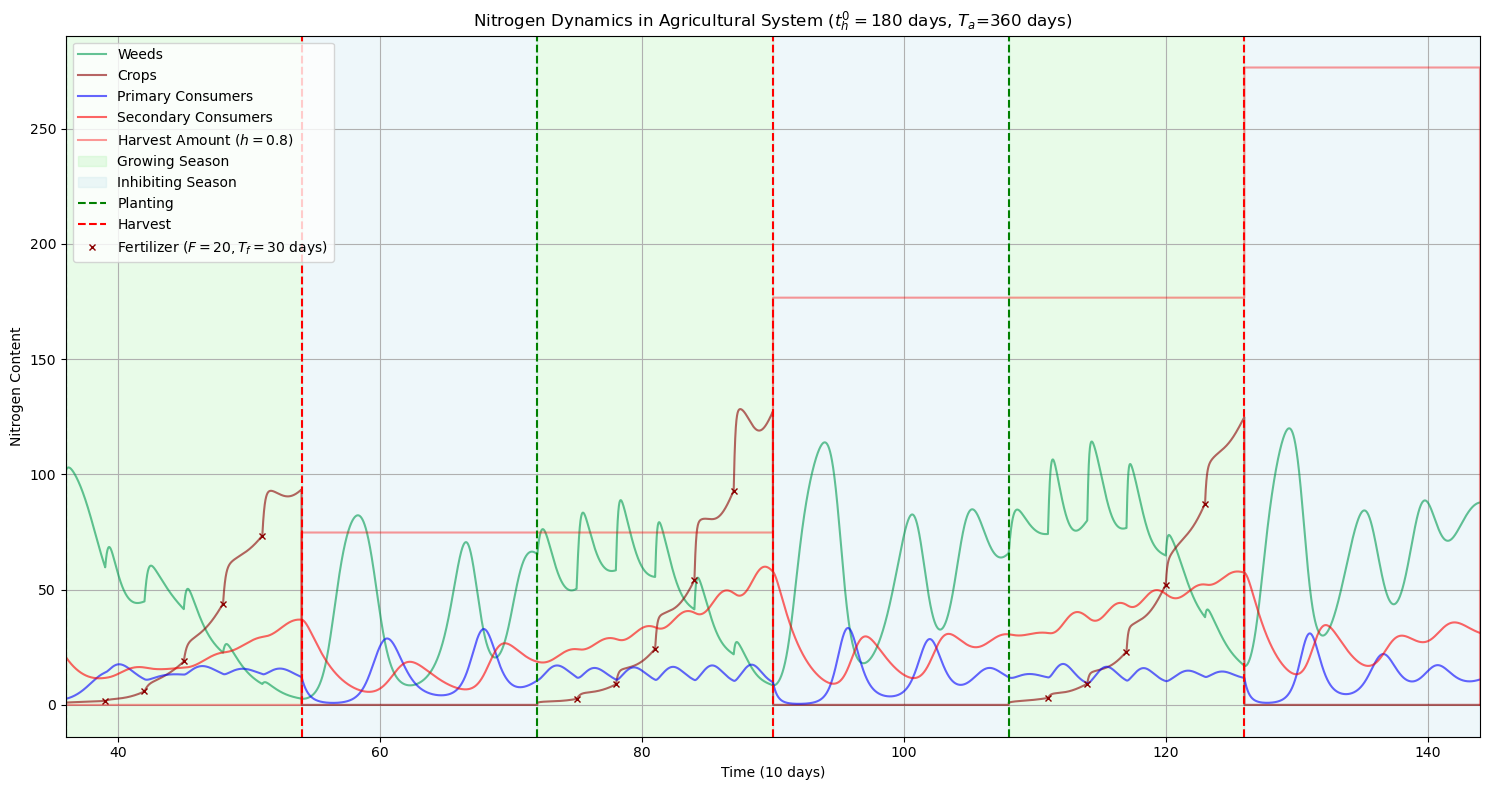

276.4969190554964


In [ ]:
# neither insecticides nor herbicide
# Competition coefficients
c_wc = 0.0003
c_cw = 0.0003

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 30000             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

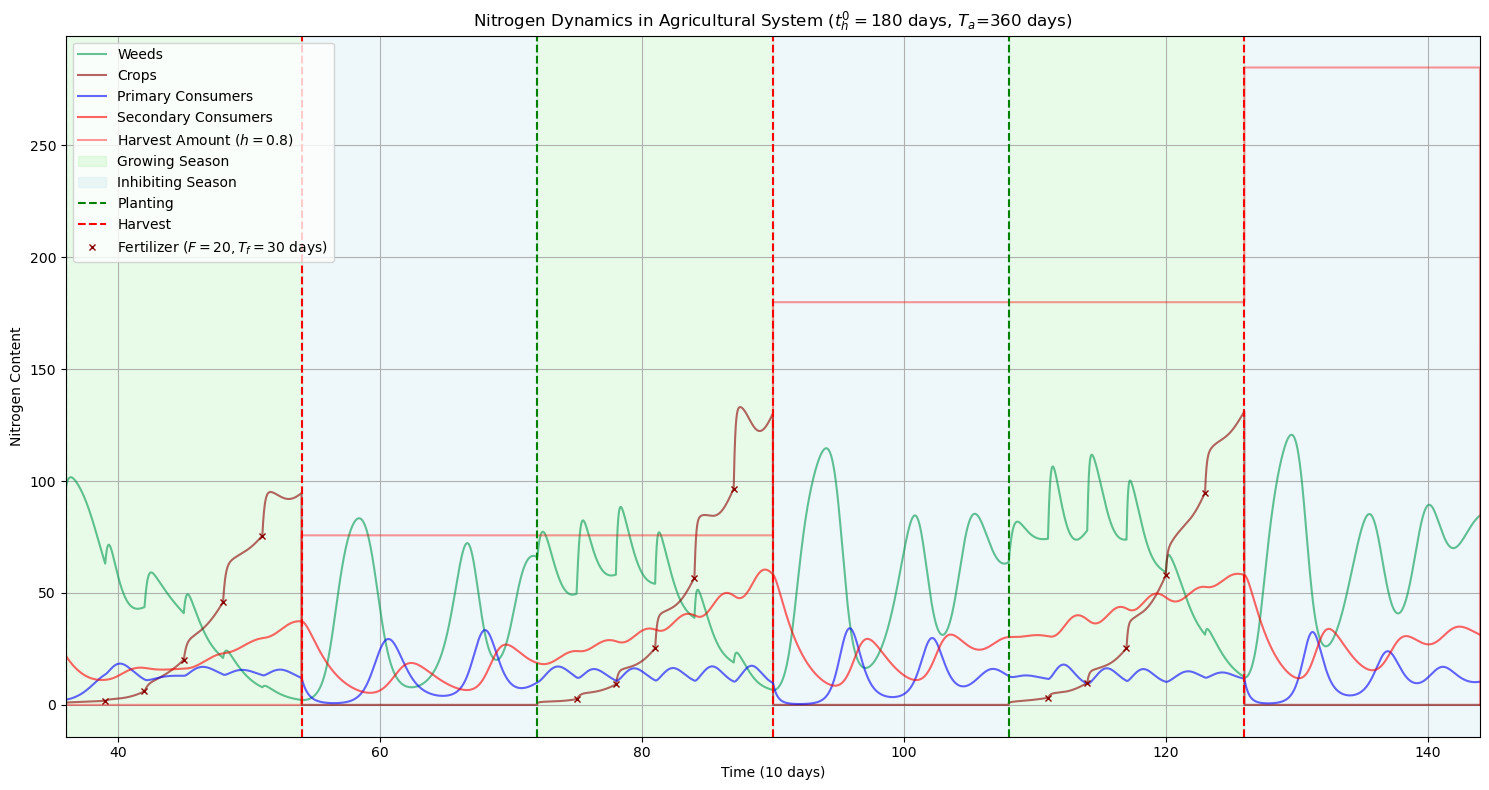

284.82199591409056


In [ ]:
# neither insecticides nor herbicide
# Competition coefficients
c_wc = 0.0002
c_cw = 0.0005

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 1     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 30000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 30000             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.05  # baseline growth rate of weeds
r_w_season = 0.04  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.04  # seasonal amplitude for crops
gamma_1_0 = 0.03  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5])  # initial death rates for consumers
alpha_w1 = 0.05
alpha_c1 = 0.025
alpha = np.array([0.05])
beta_w1 = 0.02
beta_c1 = 0.02
beta = np.array([0.04])
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 144
dt = 0.002
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((2, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [3, 1]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Primary Consumer (with seasonal death rate)
    N[0,i+1] = N[0,i] + dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i] - 
                              current_gamma[0] * N[0,i] - alpha[0] * N[0,i] * N[1,i])
    
    # Secondary Consumer
    N[1,i+1] = N[1,i] + dt * (beta[0] * N[0,i] * N[1,i] - current_gamma[1] * N[1,i])

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
    if n_a == 0:
        harvest[i] = 0


# Plot results
plt.figure(figsize=(15, 8))

# First subplot: Population dynamics
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Primary Consumers', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Secondary Consumers', color='red', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.4)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_c[int(i*T_f/dt)], 'x', color='darkred', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print(harvest[-2])

After the calculating above, we have the data below:

```python
data = np.array([
    [296.7883191, 159.5676999, 262.1529643],
    [297.0648715, 198.370539, 276.4969191],
    [296.9122727, 218.0844432, 284.8219959]
])
```

<Figure size 1000x600 with 0 Axes>

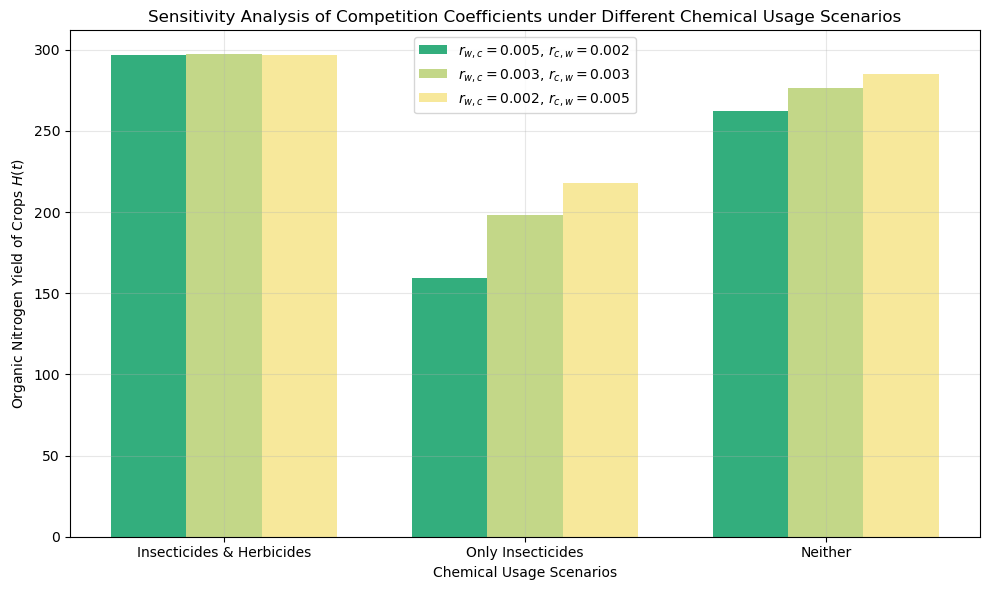

In [ ]:
# Figure 14 Sensitivity Between Harvest Amount and Competition Coefficients


# Convert the data into a numpy array
data = np.array([
    [296.7883191, 159.5676999, 262.1529643],
    [297.0648715, 198.370539, 276.4969191],
    [296.9122727, 218.0844432, 284.8219959]
])
plt.figure(figsize=(10, 6))
# Set up the bar positions
bar_width = 0.25
positions = np.arange(3)

plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Create bars for each row
plt.figure(figsize=(10, 6))
plt.bar(positions - bar_width, data[0], bar_width, label=r'$r_{w,c} = 0.005$, $r_{c,w} = 0.002$', color= '#009a5d' ,alpha=0.8)
plt.bar(positions, data[1], bar_width, label=r'$r_{w,c} = 0.003$, $r_{c,w} = 0.003$', color= '#b5cd6a', alpha=0.8)
plt.bar(positions + bar_width, data[2], bar_width, label=r'$r_{w,c} = 0.002$, $r_{c,w} = 0.005$', color= '#f6e382', alpha=0.8)

# Customize the plot
plt.xlabel('Chemical Usage Scenarios')
plt.ylabel(r'Organic Nitrogen Yield of Crops $H(t)$')
plt.title('Sensitivity Analysis of Competition Coefficients under Different Chemical Usage Scenarios')
plt.legend()
plt.xticks(positions, ['Insecticides & Herbicides', 'Only Insecticides', 'Neither'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()